# 03 - Semantic Chunking Strategy

Chunking documents based on different strategies will result in significant differences in search relevance. These differences vary based on the length of the documents being chunked. This approach differs from previous naive methods in that measures the semantic meaning of text and attempts to group sequential sentences that have similar meaning together. This results in varying chunk lengths that can make some aspects of planning the augmentation step a little more complicated. More on that later! 

Semantic chunking is much more tailored to our data, however it is computationally expensive, taking more time and money to run than the first 2 experiments.

As we called out in the [baseline experiment](01-Baseline%20Strategy.ipynb), all strategies will be impacted by the choice of embedding model, but given it is a core parameter in determining the similarity of blocks of text, this appraoch is more vulnerable than others. 

For more information on this experiment and it's outcome see the [semantic experiment definition](experiments/04-chunking-strategies-semantic.md)

## Setting up the Experiment

Having ran [00-Chunking Strategies](./00-Chunking%20Strategies.ipynb) we now have our base data and our evaluation dataset. Now it's time to run our first experiment!

Given a dataframe containing our chunked documents we must:

- Explore the semantic relationship between sentences in our documents
- Chunk the documents
- Embed the chunks
- Store it in a vector database.
- Use a helper function to run the generation and evaluation

Let's follow our [semantic experiment](experiments/04-chunking-strategies-semantic.md)). 

In [ ]:
import pandas as pd
from pathlib import Path
import mlflow
import os

# Params
top_k = 5

# Models
generation_model = os.getenv('GEN_STEP_MODEL')
evaluation_model = os.getenv('EVAL_STEP_MODEL')

# Experiment
experiment_name = f"semantic_pubmed_articles_{top_k}"
evaluation_data = pd.read_csv('data/qa_pairs.csv')
input_data = pd.read_csv('data/docs_subset.csv')

# Check if the experiment already exists
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    # If the experiment does not exist, create it
    experiment_id = mlflow.create_experiment(
        experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags={"version": "v1", "priority": "P1"},
    )
else:
    # If the experiment exists, get its ID
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_id)
   

#### Chunking the Documents

The semantic chunking strategy attempts to group text together by looking at the cosine similarity between sequential groups of sentences. The aim is to select a cosine distance threshold would represent a change in the "semantic meaning" from one chunk to the next. The art here is choosing a threshold. We can do this by calculating the cosine similarities, deriving the cosine distances and then checking the statistics. As always a few visualisations should help!

> NOTE: $$Cosine Distance = 1 - Cosine Similarity$$ 

When the cosine distance between sentences is above the defined threshold, we create a break point. There are many ways of setting the threshold, by default the langchain implementation of semantic chunking uses the 95th percentile.

In [ ]:
# Embed each of the chunks and visualise the sequential cosine similarity between the chunks plotting the graph
import numpy as np
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from sklearn.metrics.pairwise import cosine_similarity

embeddings = AzureOpenAIEmbeddings(model=os.getenv('AZURE_OPENAI_EMBEDDING_MODEL'),
                                      azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
                                      openai_api_key=os.getenv('AZURE_OPENAI_API_KEY'))


# Check if the dataframe is already in memory to save on compute iterations 
if 'ds_sentences' not in globals():
    # Create a new dataframe where each row holds a single sentence and embed them
    sentences = []
    doc_ids = []
    for idx, row in input_data.iterrows():
        for sentence in row['article'].split('.'):
            if sentence:
                sentences.append(sentence)
                doc_ids.append(row['doc_id'])

    ds_sentences = pd.DataFrame({'doc_id': doc_ids, 'sentence': sentences})

    if ('sentence_embeddings' not in ds_sentences.columns):
        ds_sentences['sentence_embeddings'] = embeddings.embed_documents(ds_sentences['sentence'])


if  ('cosine_similarity' not in ds_sentences.columns):
    # Calculate the cosine similarity between sequential chunks e.g. compare 1 to 0, 2 to 1 and so on
    cosine_similarities = []
    for i in range(1, len(ds_sentences)):
        cosine_similarities.append(cosine_similarity(np.array(ds_sentences['sentence_embeddings'][i-1]).reshape(1,-1), np.array(ds_sentences['sentence_embeddings'][i]).reshape(1,-1))[0][0])
        cosine_distances = 1 - np.array(cosine_similarities)

    ds_sentences['cosine_similarity'] = [np.nan] + cosine_similarities
    ds_sentences['cosine_distance'] = [np.nan] + cosine_distances.tolist()

# Plot the cosine similarity distribution and the sequential cosine similarity
import seaborn as sns
import matplotlib.pyplot as plt

top_percentile = 0.95
bottom_percentile = 0.05

fig, axs = plt.subplots(1, 2, figsize=(20, 6), width_ratios=[1,2])
sns.histplot(ds_sentences['cosine_distance'], kde=True, ax=axs[0])
axs[0].set_xlabel('Cosine Distance')
axs[0].set_title('Cosine Distance Distribution')
axs[0].axvline(x=ds_sentences['cosine_distance'].quantile(bottom_percentile), color='g', linestyle='--')
axs[0].axvline(x=ds_sentences['cosine_distance'].quantile(top_percentile), color='g', linestyle='--')
axs[0].axvline(x=ds_sentences['cosine_distance'].mean(), color='r', linestyle='--')
axs[0].legend(['Cosine Distance', f'Bottom {bottom_percentile*100}%', f'Top {top_percentile*100}%', 'Mean'])

axs[1].plot(ds_sentences['cosine_distance'])
axs[1].axhline(y=ds_sentences['cosine_distance'].quantile(bottom_percentile), color='g', linestyle='--')
axs[1].axhline(y=ds_sentences['cosine_distance'].quantile(top_percentile), color='g', linestyle='--')
axs[1].axhline(y=ds_sentences['cosine_distance'].mean(), color='r', linestyle='--')
axs[1].legend(['Cosine Distance', f'Bottom {bottom_percentile*100}%', f'Top {top_percentile*100}%', 'Mean'])
axs[1].set_xlabel('Sentence Index')
axs[1].set_ylabel('Cosine Distance')
axs[1].set_title('Sequential Cosine Distance')
plt.show()

# Print out the number of values above the top percentile
top_percentile_values = ds_sentences[ds_sentences['cosine_distance'] > ds_sentences['cosine_distance'].quantile(top_percentile)]
print(f"Number of values above the top {top_percentile*100}% percentile: {len(top_percentile_values)}")
#Print the standard deviation of the cosine distance
print(f"Standard deviation of the cosine distance: {ds_sentences['cosine_distance'].std()}")

An initial glance shows that there are 327 breakpoints if we were to use the 95th percentile. More breakpoints leads to a larger number of smaller chunks.

Before we accept this as a good measure, let's take a look at some sentences that are very similar and very dissimilar.

In [ ]:
from pprint import pprint

bottom_k_indices = ds_sentences['cosine_distance'].nsmallest(top_k).index

bottom_k_sentences = ds_sentences.loc[bottom_k_indices]

print("**********--- Similar Sentences ---**********")
for idx, row in bottom_k_sentences.iterrows():
    print(f"Doc ID: {row['doc_id']}")    
    pprint(f"Previous Sentence: {ds_sentences.loc[idx-1]['sentence']}")
    pprint(f"Sentence: {row['sentence']}")
    print(f"Cosine Distance: {row['cosine_distance']}")
    print()

# Find the indicies of the top 5 highest cosine distances
top_k_indices = ds_sentences['cosine_distance'].nlargest(top_k).index

# Extract the top k sentences and the sentences prior, and print them out
print("**********--- Dissimilar Sentences ---**********")
top_k_sentences = ds_sentences.loc[top_k_indices]
for idx, row in top_k_sentences.iterrows():
    print(f"Doc ID: {row['doc_id']}")    
    pprint(f"Previous Sentence: {ds_sentences.loc[idx-1]['sentence']}")
    pprint(f"Sentence: {row['sentence']}")
    print(f"Cosine Distance: {row['cosine_distance']}")
    print()


On the dissimilar front, all is looking good, with sentences switching from biomedical topics to software (there could of course be times where this is important information, for example when the method of measurement is critical to the phenomena being described - consult your SME!).

Similar sentences look a little problematic in that there's definite repetition. Some times of values which could be from tables, sometimes entire sentences. This indicates potential problems with the data that could be impacting all of our experiments. 

For the semantic method, this means we'll have potential duplicatation within our chunks. Not ideal, as it increases token counts and may cause unexpected behaviour in the generation step. It''d be a good idea to review these documents to understand what's going on. However, for now, we'll assume that any duplication is ok.

Let's carry on and take a look at the implementation of semantic chunking in Langchain.

This implementation differs from our sentence by sentence approach by collating sentences into groups of three before the embedding step, the idea being to reduce noise. This can be adjusted by adding the `buffer_size` parameter to the sentence splitter call. This is the number of sentences both before an after each sentence that should be grouped.

For an illustration of how this works, see the below example.

In [ ]:
import json

text = "This is the first sentence. Here is the second. This is the third sentence. The fourth sentence is here. This is sentence number five. Here is the sixth sentence. This is the seventh. The eighth sentence is here. This is sentence number nine. Here is the tenth sentence."

# Split the text into sentences
sentences = text.split('. ')

# Initialize an empty dictionary to hold the JSON object
json_obj = {}

# Iterate over the sentences
for i in range(len(sentences)):
    internal_obj = {}
    # Get the two sentences before and after the current sentence
    before = sentences[max(0, i - 2):i]
    after = sentences[i + 1:min(len(sentences), i + 3)]
    
    # Combine the sentences into a single string
    combined = ' '.join(before + [sentences[i]] + after)
    
    # Add the combined string to the JSON object
    internal_obj['combined'] = combined

    # Add the internal object to the JSON object
    json_obj[i] = internal_obj

# Convert the dictionary to a JSON string
json_str = json.dumps(json_obj, indent=4)

pprint(json_str)

The value under the combined key is what is embedded as the raw input to the cosine distance calculation. This is useful if you find that your output is a little noisy. For now, let's proceed with the defaults.

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

# Check if the chunked data already exists
if os.path.exists(f'data/{experiment_name}-chunks.csv'):
    print(f"Chunked data already exists at data/{experiment_name}-chunks.csv")
    ds_chunked = pd.read_csv(f'data/{experiment_name}-chunks.csv')
    print(f"Loaded {len(ds_chunked)} chunks")

else:

    text_splitter = SemanticChunker(embeddings)
    # Create a new DataFrame with each chunk as a separate row
    chunks = []
    doc_ids = []
    chunk_ids = []
    for idx, row in input_data.iterrows():
        article_chunks = [chunk.page_content for chunk in text_splitter.create_documents([input_data['article'][idx]])]
        chunks.extend(article_chunks)
        doc_ids.extend([row['doc_id']] * len(article_chunks))
        chunk_ids.extend([f"{row['doc_id']}-{i+1}" for i in range(len(article_chunks))])

    ds_chunked = pd.DataFrame({'doc_id': doc_ids, 'chunk_id': chunk_ids, 'chunks': chunks})
    ds_chunked.to_csv(f'data/{experiment_name}-chunks.csv', index=False)

Let's take a look at some of our chunks - it helps to do a sense check as if we see something wrong, it's a lot easier to fix now than after creating your embeddings and search indexes.

In [ ]:
from pprint import pprint

# display a random sample of the chunked data show the full string
for chunk in ds_chunked['chunks'].sample(5):
    pprint(chunk)
    print('\n') 

On the surface, the groupings seem reasonable. Though it is worth consulting an SME and reviewing select document to be confident that the content of the chunks is semantically consistent for the domain.

Now we have some chunks - let's have a look at the number of words that they contain to give us an idea of whether we need to modify our retrieval step.

In [ ]:
# Lets use seaborn to plot the distribution of the chunk sizes
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ds_chunked['chunks'].apply(lambda x: len(x.split())), kde=True)
plt.xlabel('Chunk Length (words)')
plt.show()




In [ ]:
ds_chunked['chunks'].apply(lambda x: len(x.split())).describe()

We can see that these chunks are on average a similar size to those that we have worked with in previous experiments. We are using a model with a 16k context window so we can be fairly confident that we won't exceed it in our generation step. In practice this is where we would implement a strict token limit on what can be passed to the generation step. We'll talk about that in a bit more detail later.

Let's ingest our chunks into our vector database and proceed with our retrieval step.

### Embed the Chunks and Load the Index

As before, we will use the `ada-v2` embedding model and the chroma database to create our index.

In [ ]:
import chromadb.utils.embedding_functions as embedding_functions
from dotenv import find_dotenv, load_dotenv
import os

load_dotenv(find_dotenv())   
# Specify Embedding model
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

# Used in chromadb to embed docs and queries
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_type="azure",
                api_version=os.getenv("OPENAI_API_VERSION"),
                model_name=embedding_model
            )
# Create a new collection in ChromaDB
from chromadb import PersistentClient

chroma_client = PersistentClient(path="./data/chroma_db")

index_name = f"experiment_{experiment_name}"
collection = chroma_client.get_or_create_collection(name=index_name,embedding_function=openai_ef, metadata={"hnsw:space": "cosine"})

# Batch the embeddings into groups of 500 and add them to chroma
# This is necessary because there is an undocumented limit to the number of documents 
# That can be sent to the Azure API in a single request

for i in range(0, len(ds_chunked), 500):
    collection.add(
        documents=ds_chunked['chunks'].tolist()[i:i+500],
        metadatas=[{"doc_id": doc_id} for doc_id in ds_chunked['doc_id'][i:i+500]],
        ids=ds_chunked['chunk_id'].tolist()[i:i+500]
    )


## Run the Experiment and Evaluation

We will be using the same setup and evaluation as in the previous notebook, but this time we will run the experiment and the evaluation in one go. This can take around 5-10 minutes with GPT35 Turbo, so grab a coffee!

In [ ]:
from multiprocessing import Pool
from pprint import pprint
from helper.openai_utils import general_prompt, create_client
from rag.augmentation import get_context, contruct_prompt
from eval.evaluate import ragas_evaluate

multi_threading = True
oai_client = create_client()

if os.path.exists(f'data/{experiment_name}-{generation_model}-results.csv'):
    print("File exists, reading in...")
    import os
    import ast
    import pandas as pd
    from dotenv import find_dotenv, load_dotenv

    load_dotenv(find_dotenv())

    results_df = pd.read_csv(f'data/{experiment_name}-{generation_model}-results.csv')

    # Convert the contexts to a list of strings using ast
    results_df['contexts'] = results_df['contexts'].apply(ast.literal_eval)

else:
    #Create a distinct copy of evaluation_data to store the results
    results_df = evaluation_data.copy()

    def generation_step(question):
        context = get_context(question, collection,top_k)
        prompt = contruct_prompt(context, question)
        return general_prompt(oai_client, prompt, model=generation_model)

    if multi_threading == True:
        with Pool() as pool:
            results_multiprocessing = pool.map(generation_step, results_df['question'])
        results_df['answer'] = results_multiprocessing

    else:
        results_df['answer'] = results_df['question'].apply(lambda x: generation_step(x))

    #TODO: Refactor this so only one call for context

    # Check if the column exists
    if 'contexts' not in results_df.columns:
        results_df['contexts'] = [get_context(q, collection) for q in results_df['question']]

    #write out to CSV
    results_df.to_csv(f'data/{experiment_name}-{generation_model}-results.csv', index=False)


# Calculate metrics and store
import json
from eval.evaluate import ragas_evaluate

# check if csv and json files exist
if (os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv') and 
    os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json')):

    print("File exists, reading in...")
    pd_results = pd.read_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv')
    
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'r') as f:
        results = json.load(f)


else:
# Calculate metrics and store
    results = ragas_evaluate(results_df,evaluation_model=evaluation_model)
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'w') as f:
        json.dump(results, f)
    pd_results = results.to_pandas()
    pd_results.to_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv', index=False)

from pprint import pprint
pprint(results)
display(pd_results)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param("experiment_name", experiment_name)
    mlflow.log_param("top_k", top_k)
    mlflow.log_param("embedding_model", embedding_model)
    mlflow.log_param("generation_model", generation_model)
    mlflow.log_param("evaluation_model", evaluation_model)

    mlflow.log_metric("failthfulness", results['faithfulness'])
    mlflow.log_metric("answer_relevancy", results['answer_relevancy'])
    mlflow.log_metric("answer_similarity", results['answer_similarity'])

## Review the Ouput

Now that we have logged our experiment metrics. Let's compare and contrast them with the results of the previous experiments. 

In [ ]:
!mlflow server --host 127.0.0.1 --port 8080

We can now select the three experiments, and the runs that we are interested in comparing. Below are some examples from previous runs.

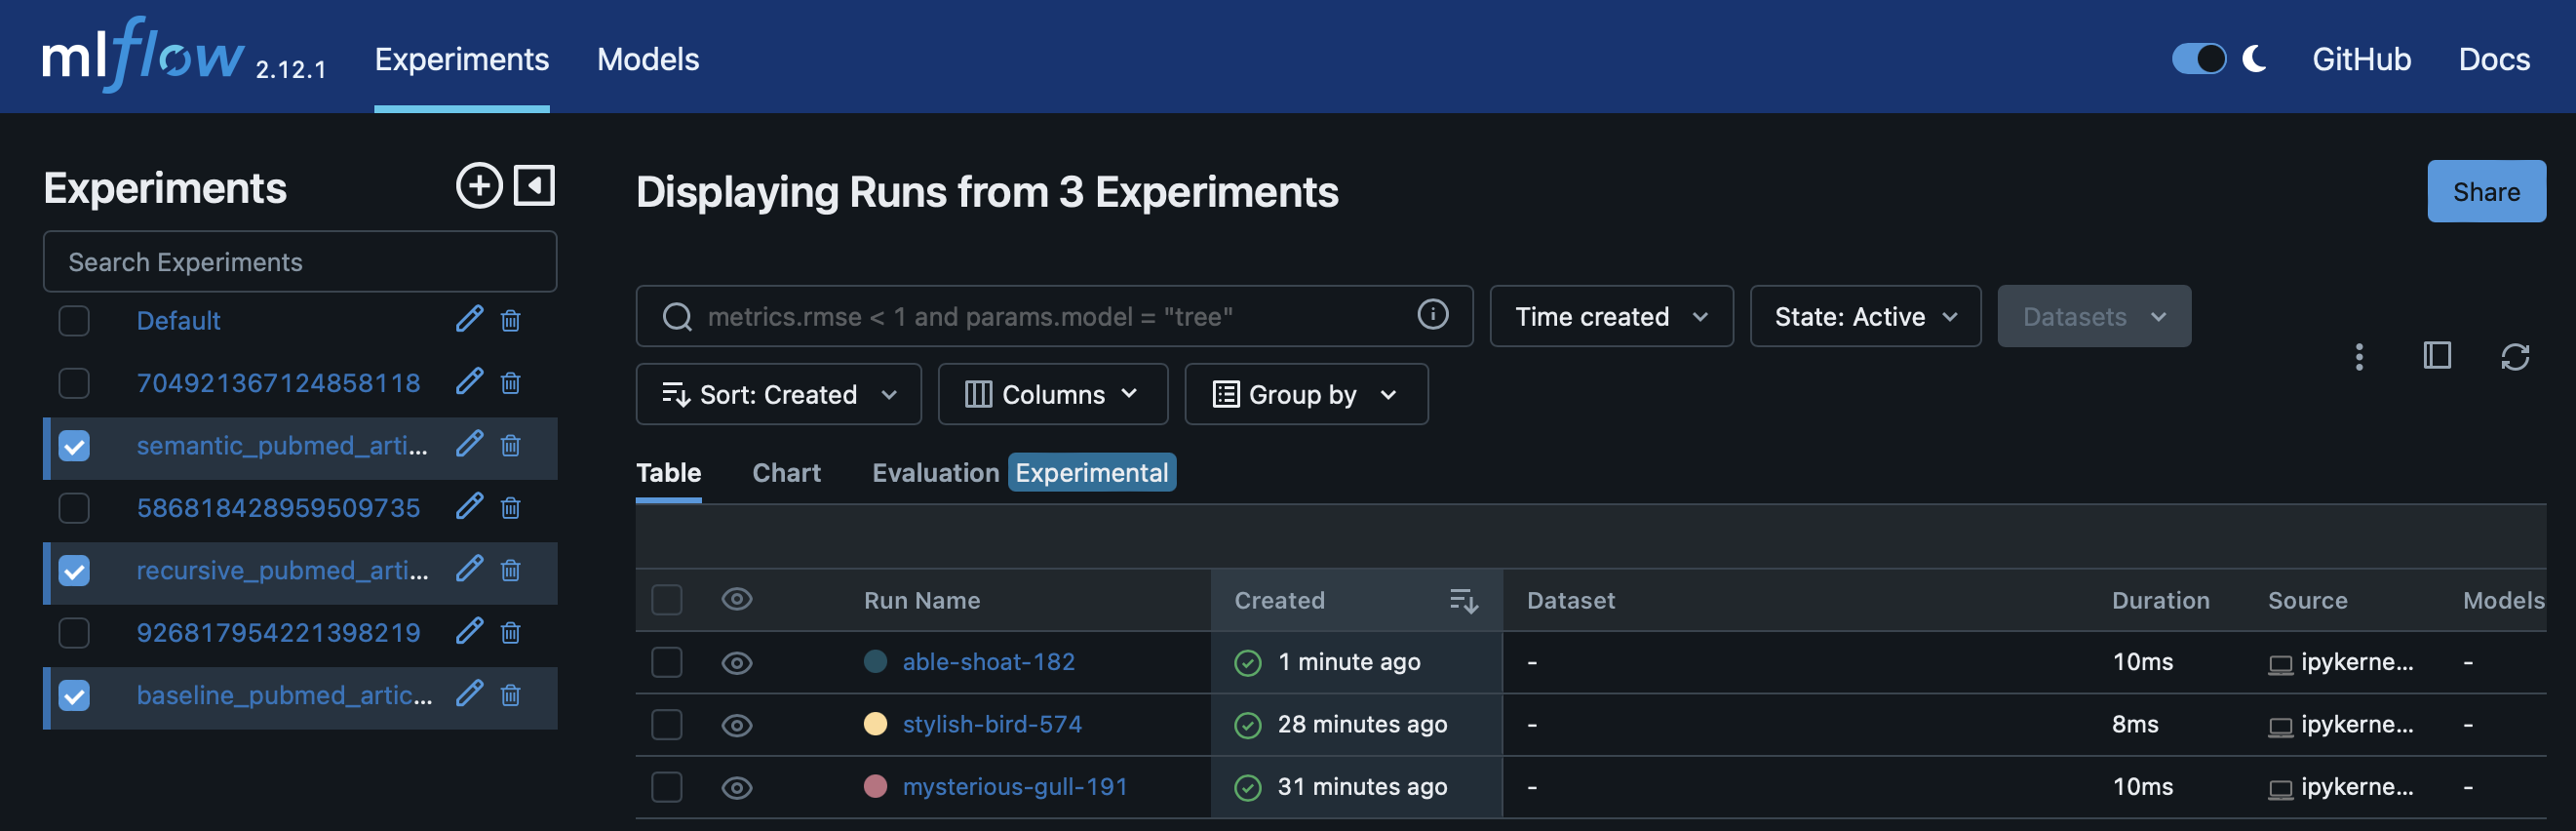

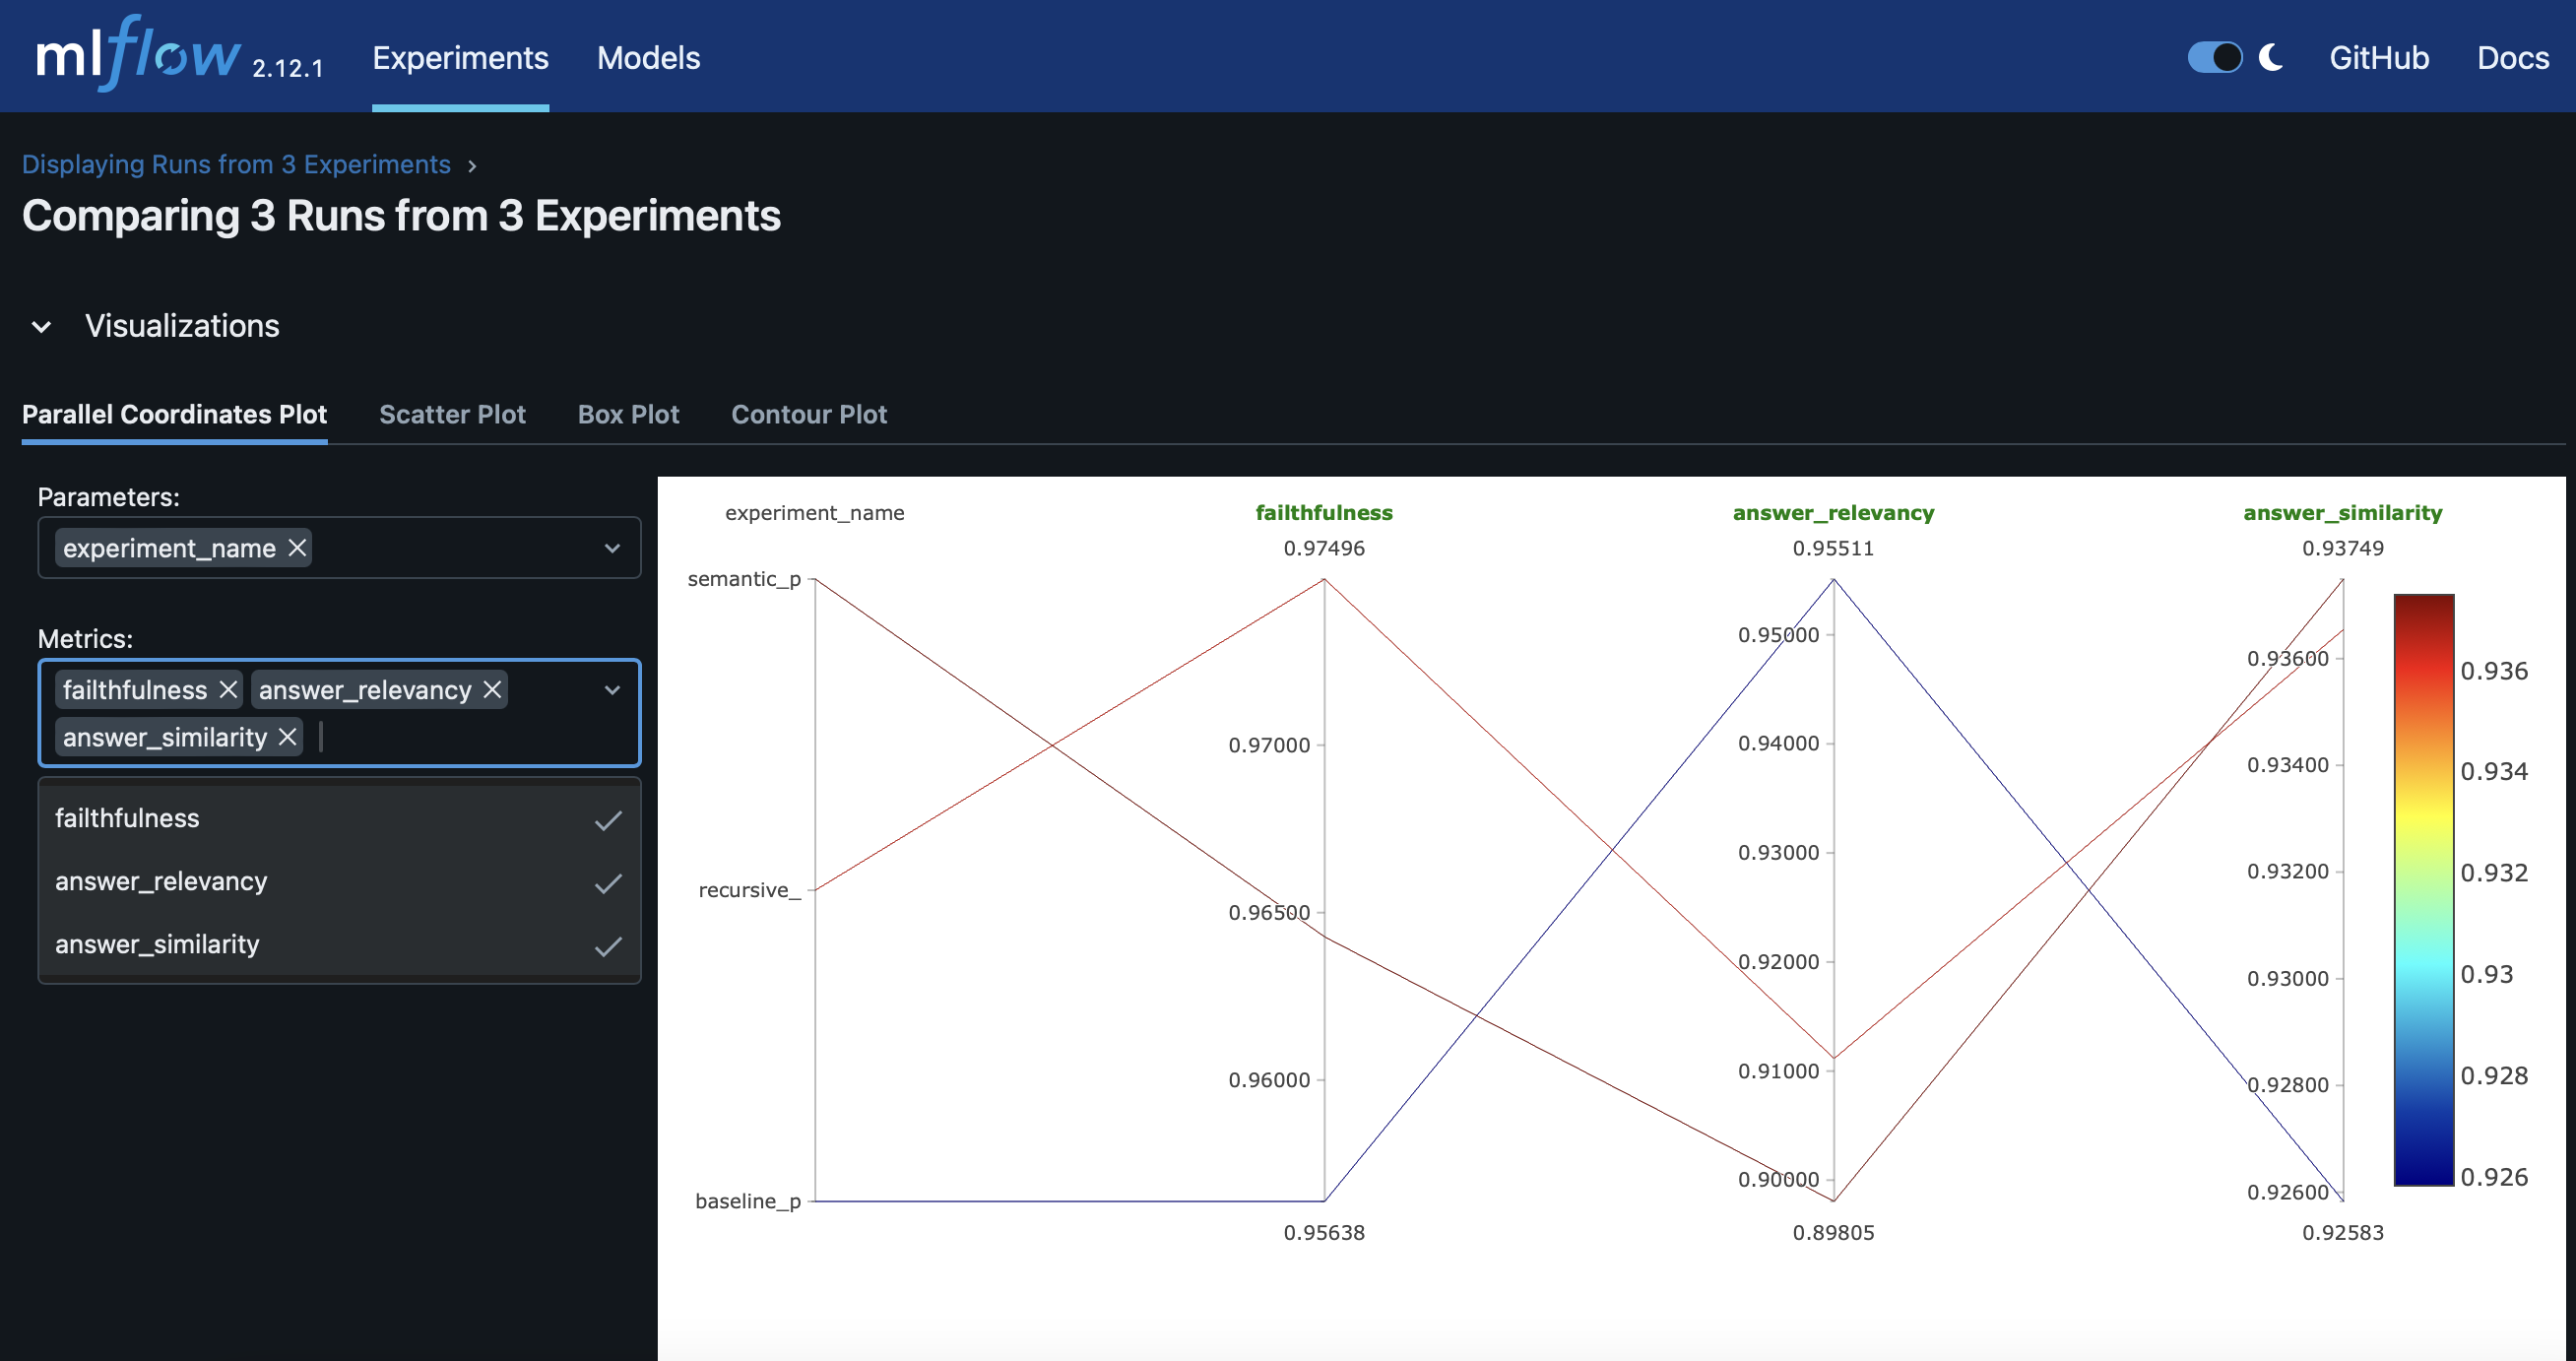

<TODO: INSERT ANALYSIS>

As a reminder, here are the definitions:

1. *Faithfulness*: This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

2. *Answer Relevancy*: The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy.

3. *Answer Semantic Similarity*: The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

<TODO: INSERT ANALYSIS>

What's clear so far is that based on metrics alone, there isn't a clear winner for the approach. 

Let's compare these results to our baseline metrics and test to see if there's a difference, and then compare with the recursive results. For this we will use [Wilcoxon test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) with an alpha of 0.05. 

In [ ]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

baseline_results = pd.read_csv('/home/guy/projects/aip/chunky_monkey/chunking_strategies/data/baseline_pubmed_articles_400_50_5-gpt-35-turbo-16k-gpt-35-turbo-16k-evaluated.csv')
recursive_results = pd.read_csv('/home/guy/projects/aip/chunky_monkey/chunking_strategies/data/recursive_pubmed_articles_1500_100_5-gpt-35-turbo-16k-gpt-35-turbo-16k-evaluated.csv')
current_results = pd.read_csv('/home/guy/projects/aip/chunky_monkey/chunking_strategies/data/semantic_pubmed_articles_5-gpt-35-turbo-16k-gpt-35-turbo-16k-evaluated.csv')


# Visualise the difference in the metrics between the baseline and the current results using their means and standard deviations
# Create a table to display the results

evaluation_comp = pd.DataFrame({
    'Baseline': [baseline_results['faithfulness'].mean(), baseline_results['answer_relevancy'].mean(), baseline_results['answer_similarity'].mean()],
    'Current': [current_results['faithfulness'].mean(), current_results['answer_relevancy'].mean(), current_results['answer_similarity'].mean()],
    'Baseline Std': [baseline_results['faithfulness'].std(), baseline_results['answer_relevancy'].std(), baseline_results['answer_similarity'].std()],
    'Current Std': [current_results['faithfulness'].std(), current_results['answer_relevancy'].std(), current_results['answer_similarity'].std()],
}, index=['Faithfulness', 'Answer Relevancy', 'Answer Similarity'])

print("*****--- Evaluation Comparison ---*****")
display(evaluation_comp)

print("*****--- Distribution of metrics across experiments ---*****")
# Plot the distribution of the metrics for the baseline and current results

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(baseline_results[metric], kde=True, ax=axs[idx], color='blue', label='Baseline')
    sns.histplot(current_results[metric], kde=True, ax=axs[idx], color='red', label='Semantic')
    axs[idx].set_xlabel(metric)
    axs[idx].legend()

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(current_results[metric] - baseline_results[metric], kde=True, ax=axs[idx])
    axs[idx].set_xlabel(f"{metric} difference")

print("*****--- Distribution of differences ---*****")
plt.show()

# For each of the metrics, calculate the difference between the baseline and the current results
# The perform a statistical test to see if they are significantly different
# use the mann whitney u test

print("*****--- Wilcoxon Test ---*****")
print("Null Hypothesis: The distribution of the metric is the same for the baseline and current results")
print("Alternative Hypothesis: The distribution of the metric is different for the baseline and current results")
print("\n")

for metric in ['faithfulness', 'answer_relevancy', 'answer_similarity']:
    baseline_metric = baseline_results[metric]
    current_metric = current_results[metric]

    # Perform the Wilcoxon test
    statistic, p_value = wilcoxon(baseline_metric, current_metric)

    print(f"{metric} p-value: {p_value}")


<TODO: INSERT ANALYSIS>

How does it compare to recursive chunking? Let's repeat the analysis.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Repeat for current results and recursive results

evaluation_comp = pd.DataFrame({
    'Recursive': [recursive_results['faithfulness'].mean(), recursive_results['answer_relevancy'].mean(), recursive_results['answer_similarity'].mean()],
    'Current': [current_results['faithfulness'].mean(), current_results['answer_relevancy'].mean(), current_results['answer_similarity'].mean()],
    'Recursive Std': [recursive_results['faithfulness'].std(), recursive_results['answer_relevancy'].std(), recursive_results['answer_similarity'].std()],
    'Current Std': [current_results['faithfulness'].std(), current_results['answer_relevancy'].std(), current_results['answer_similarity'].std()],
}, index=['Faithfulness', 'Answer Relevancy', 'Answer Similarity'])

print("*****--- Evaluation Comparison ---*****")
display(evaluation_comp)

# Plot the difference in the metrics between the baseline and the current results using seaborn


print("*****--- Distribution of metrics across experiments ---*****")
# Plot the distribution of the metrics for the baseline and current results


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(recursive_results[metric], kde=True, ax=axs[idx], color='blue', label='Recursive')
    sns.histplot(current_results[metric], kde=True, ax=axs[idx], color='red', label='Semantic')
    axs[idx].set_xlabel(metric)
    axs[idx].legend()

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(current_results[metric] - recursive_results[metric], kde=True, ax=axs[idx])
    axs[idx].set_xlabel(f"{metric} difference")

print("*****--- Distribution of differences ---*****")
plt.show()


# For each of the metrics, calculate the difference between the baseline and the current results
# The perform a statistical test to see if they are significantly different
# use the mann whitney u test

print("*****--- Wilcoxon Test ---*****")
print("Null Hypothesis: The distribution of the metric is the same for the baseline and current results")
print("Alternative Hypothesis: The distribution of the metric is different for the baseline and current results")
print("\n")

for metric in ['faithfulness', 'answer_relevancy', 'answer_similarity']:
    recursive_metric = recursive_results[metric]
    current_metric = current_results[metric]

    # Perform the Wilcoxon test
    statistic, p_value = wilcoxon(recursive_metric, current_metric)

    print(f"{metric} p-value: {p_value}")

<TODO: INSERT ANALYSIS>